# Graph Auto-Encoder (GAE)

This file is for design purposes - will first try it with one dataset and one way of representing, and then move on to other datasets and ways of representing it. Based on https://github.com/pyg-team/pytorch_geometric/blob/master/examples/autoencoder.py.

**Note: I'm trying to work with sparse matrices as much as possible. If this is not possible, I will need to change back to dense matrices. But for memory efficiency, sparse matrices are much better.**

## Import packages

In [1]:
# import packages
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.transforms import RandomLinkSplit
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

# import python files needed to create adjacency matrices
import reading_data

## Read in data

In [4]:
# for the AIFB+, filtered, not-relational, sparse
adjacency_matrix, mapping_index_to_node, mapping_entity_to_index = reading_data.create_adjacency_matrix_nt("data/aifb/aifb+.nt", literal_representation="separate", sparse=True)
number_nodes = adjacency_matrix.size()[0]

In [5]:
adjacency_matrix.coalesce().indices()

tensor([[    0,     0,     0,  ...,  2834,  2834,  2834],
        [   57,   111,   157,  ...,  8718, 10658, 10993]])

## Create feature matrix (one-hot)

In [6]:
feature_matrix = torch.sparse_coo_tensor(indices=torch.tensor([list(range(number_nodes)), list(range(number_nodes))]), values=torch.ones(number_nodes),size=(number_nodes, number_nodes))

In [7]:
feature_matrix

tensor(indices=tensor([[    0,     1,     2,  ..., 11537, 11538, 11539],
                       [    0,     1,     2,  ..., 11537, 11538, 11539]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(11540, 11540), nnz=11540, layout=torch.sparse_coo)

## Create a data object

In [8]:
data_aifb = Data(x=feature_matrix, edge_index=adjacency_matrix.coalesce().indices(), num_nodes=number_nodes)

In [9]:
data_aifb

Data(x=[11540, 11540], edge_index=[2, 29043], num_nodes=11540)

In [10]:
data_aifb.is_directed()

True

In [11]:
data_aifb.num_node_features

11540

**Split it into three:**

In [12]:
# set up a link split function --> have to split the labels into positive and negative
transformation = RandomLinkSplit(split_labels=True, add_negative_train_samples=False)

# split the data into a train, validation and test set
aifb_train, aifb_val, aifb_test = transformation(data_aifb)

In [13]:
aifb_train

Data(x=[11540, 11540], edge_index=[2, 20331], num_nodes=11540, pos_edge_label=[20331], pos_edge_label_index=[2, 20331])

In [14]:
aifb_val

Data(x=[11540, 11540], edge_index=[2, 20331], num_nodes=11540, pos_edge_label=[2904], pos_edge_label_index=[2, 2904], neg_edge_label=[2904], neg_edge_label_index=[2, 2904])

In [15]:
aifb_test

Data(x=[11540, 11540], edge_index=[2, 23235], num_nodes=11540, pos_edge_label=[5808], pos_edge_label_index=[2, 5808], neg_edge_label=[5808], neg_edge_label_index=[2, 5808])

Later on, this can be expanded, by, for example, adding labels and training, validation, and testing masks. For only the GAE, though, this is not needed.

## Create the GCN-encoder and the GAE

In [16]:
class GCN_encoder(torch.nn.Module):
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        super().__init__()
        self.layer1 = GCNConv(input_nodes, hidden_nodes)
        self.layer2 = GCNConv(hidden_nodes, output_nodes)
    
    def forward(self, X, A):
        h1 =  self.layer1(X, A)
        h1_activated = F.relu(h1)
        h2 = self.layer2(h1_activated, A)
        return h2

In [17]:
input_n = data_aifb.num_features
hidden_n = 200
output_n = 30
encoder = GCN_encoder(input_n, hidden_n, output_n)
model = GAE(encoder) # decoder is not needed, as it is implied

## Run a training loop

In [18]:
# needed for the training loop:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
nr_epochs = 100

In [19]:
recon_valid_run = list()
auc_valid_run = list()
ap_valid_run = list()

for epoch in range(nr_epochs):
    # set to training mode, put the grads to zero:
    model.train()
    optimizer.zero_grad()
    
    # encode everything in latent space using the encoder
    latent_space = model.encode(aifb_train.x, aifb_train.edge_index)
    
    # calculate the reconstruction loss and perform the backwards operation
    reconstruction_loss = model.recon_loss(latent_space, aifb_train.pos_edge_label_index)
    reconstruction_loss.backward()
    
    # update the parameters
    optimizer.step()
    
    # clip weights?
    # --- also, other optimization steps here ----
    
    # now, evaluate the model as it currently is, and save this information:
    model.eval()
    latent_space_valid = model.encode(aifb_val.x, aifb_val.edge_index)
    reconstruction_loss_valid = model.recon_loss(latent_space_valid, aifb_val.pos_edge_label_index, aifb_val.neg_edge_label_index) 
    AUC_valid, average_precision_valid = model.test(latent_space_valid, aifb_val.pos_edge_label_index, aifb_val.neg_edge_label_index)
    
    recon_valid_run.append(reconstruction_loss_valid.item())
    auc_valid_run.append(AUC_valid.item())
    ap_valid_run.append(average_precision_valid.item())

print(recon_valid_run)
print(auc_valid_run)
print(ap_valid_run)

[1.362058162689209, 1.3049805164337158, 1.2319586277008057, 1.1931350231170654, 1.2105778455734253, 1.2018848657608032, 1.1695587635040283, 1.145520567893982, 1.1412158012390137, 1.1530671119689941, 1.174067735671997, 1.2094134092330933, 1.2664648294448853, 1.3396999835968018, 1.4155144691467285, 1.4764573574066162, 1.512782096862793, 1.5221221446990967, 1.50689697265625, 1.4771820306777954, 1.4385019540786743, 1.3998355865478516, 1.3632429838180542, 1.3299636840820312, 1.3024499416351318, 1.2804765701293945, 1.2649717330932617, 1.2546448707580566, 1.2493585348129272, 1.2497787475585938, 1.253612995147705, 1.2611536979675293, 1.2718749046325684, 1.2846753597259521, 1.2986855506896973, 1.315173625946045, 1.3320353031158447, 1.3483083248138428, 1.3620400428771973, 1.3730206489562988, 1.382702112197876, 1.388515830039978, 1.3924429416656494, 1.392345666885376, 1.387614130973816, 1.3797048330307007, 1.3701226711273193, 1.360473871231079, 1.349714756011963, 1.340929388999939, 1.334614276885

## Analysis of results

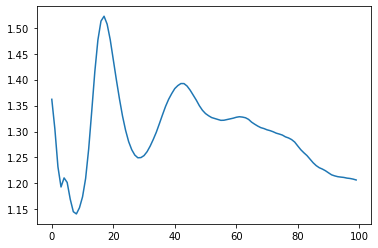

In [20]:
plt.plot(recon_valid_run)

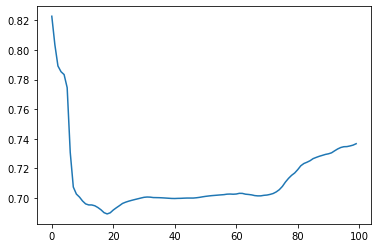

In [21]:
plt.plot(auc_valid_run)

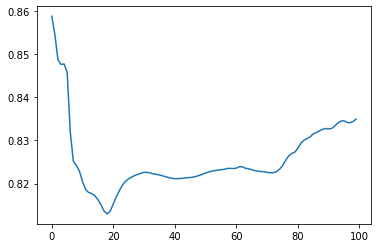

In [22]:
plt.plot(ap_valid_run)

## The streamlined version:

In [2]:
import GAE_model

# run_gae_model(dataset_filename, literal_representation, hidden_nodes, output_nodes, optimizer, learning_rate,
#                  weight_decay, nr_epochs, seed, test=True, record_results=False)

GAE_model.run_gae_model(dataset_filename="data/aifb/aifb+.nt", literal_representation="collapsed", hidden_nodes=100, output_nodes=30, optimizer="adam", learning_rate=0.05,
                  weight_decay=0.001, nr_epochs=100, seed=10, test=True, record_results=True)